In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 13.1 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab
import cv2
import glob,os
from PIL import Image as im
import imageio
from tqdm import tqdm
import skimage
from skimage import io
from skimage import color
import skimage.filters
from skimage.filters import median
from skimage.morphology import disk
from skimage import exposure
from skimage.feature import canny
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import polygon
import pydicom as dicom
from PIL import Image

class PreProcess:

    def __init__(self):
      pass

    def apply_artifact_removal(self,image):
        
        print("IMAGE SHAPE 1 : ",image.shape)
        #gray_image = image
        if len(image.shape) == 3:
          img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
          img_grey = image
        #gray_image = color.rgb2gray(image)
        hh,ww = img_grey.shape[:2]
        gray_image = img_grey.astype(np.uint8)
        print("IMAGE SHAPE 2 : ",gray_image.shape)
        print(gray_image)
        thresh = cv2.threshold(gray_image,0,255,cv2.THRESH_OTSU)[1] 
    
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
        morph = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

        contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        big_contour = max(contours, key=cv2.contourArea)

        mask = np.zeros((hh,ww), dtype=np.uint8)
        cv2.drawContours(mask, [big_contour], 0, 255, cv2.FILLED)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (55,55))
        mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)

        artifact_removed_image = cv2.bitwise_and(image, image, mask=mask)
    
        return artifact_removed_image
    
    def apply_resize_image(self,image):
        resized_image = color.gray2rgb(image)
        resized_image = cv2.resize(resized_image, (256, 256))
        
        print('JOTAROOOOOO')
        plt.imshow(resized_image,cmap='gray')
        plt.show()
        print(resized_image)
        
    def apply_crop_image(self,image):
        print('MUDAMUDAMUDMAUDMAUDMUDA')
        plt.imshow(image,cmap='gray')
        plt.show()
        image_copy = np.copy(image) 
        print('AYE DSKGBHFBG')
        plt.imshow(image_copy,cmap='gray')
        plt.show()
        #image_copy = np.array(image, dtype=np.uint8)
        print("DIOOOOOOOOO",image_copy.shape)
        plt.imshow(image_copy,cmap='gray')
        plt.show()
        img_grey = color.rgb2gray(image_copy) #change1 from gray2rgb to rgb2gray
        #img_grey = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
        plt.imshow(img_grey,cmap='gray')
        plt.show()
        img_grey = np.array(img_grey, dtype=np.uint8)
        thresh = cv2.threshold(img_grey, 0 , 255, cv2.THRESH_BINARY)[1] 
        x, y, w, h = cv2.boundingRect(thresh) #find the bounding rectangle of nonzero points in the image
        print("jbgkdfgd",x,y,w,h)
        cropped_image = image_copy[y:y+h, x:x+w,:] 
        print("SHAAAAAAAAPEEEEEE : ",cropped_image.shape)
        bgr_cropped_image = color.gray2rgb(cropped_image)
        return bgr_cropped_image

    def right_orient_mammogram(self,image):
        left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
        right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
        if(left_nonzero < right_nonzero):
            image = cv2.flip(image, 1)

        return image


            
    
    def apply_canny_sobel(self,image):
        canny_image = canny(image, 3.05) #this value works with 90-95% of the images
        return sobel(canny_image)

    def get_hough_lines(self,canny_image):
        h, theta, d = hough_line(canny_image)
        lines = list()
        print('\nAll hough lines')
        for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
            print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
            x1 = 0
            y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
            x2 = canny_image.shape[1]
            y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
            lines.append({
                'dist': dist,
                'angle': np.degrees(angle),
                'point1': [x1, y1],
                'point2': [x2, y2]
            })
    
        return lines

    def shortlist_hough_lines(self,lines):
        MIN_ANGLE = 10
        MAX_ANGLE = 70
        MIN_DIST  = 5
        MAX_DIST  = 256
    
        shortlisted_lines = [x for x in lines if 
                            (x['dist']>=MIN_DIST) &
                            (x['dist']<=MAX_DIST) &
                            (x['angle']>=MIN_ANGLE) &
                            (x['angle']<=MAX_ANGLE)
                            ]
        print('\nShorlisted lines')
        for i in shortlisted_lines:
            print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        
        return shortlisted_lines
    
    def remove_pectoral(self,shortlisted_lines):
        shortlisted_lines.sort(key = lambda x: x['dist'])
        pectoral_line = shortlisted_lines[0]
        d = pectoral_line['dist']
        theta = np.radians(pectoral_line['angle'])
    
        x_intercept = d/np.cos(theta)
        y_intercept = d/np.sin(theta)
    
        return polygon([0, 0, y_intercept], [0, x_intercept, 0])
    
        
    def pectoral_removed(self,image):
        #image = self.read_image(img)
        #image_copy = image.astype(np.uint8)
        gray_img = color.rgb2gray(image) #changed
        right_orient_img = self.right_orient_mammogram(gray_img)
        equ_image = exposure.equalize_hist(right_orient_img)

        canny_image = self.apply_canny_sobel(equ_image)
        lines = self.get_hough_lines(canny_image)
        shortlisted_lines = self.shortlist_hough_lines(lines)        
        rr, cc = self.remove_pectoral(shortlisted_lines)
        try:
            image[rr, cc] = 0
        except Exception as e:
            return e

        return image

    def remove_graypx(self,image):
        print(image)
        binary_mask = image > 80
        restored = image.copy()
        restored[~binary_mask] = 0
        return restored
    
    
    def padding(self,image):
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        old_image_h, old_image_w, channels = image.shape
        new_image_h = 256
        new_image_w = 256
        colour = (0,0,0)
        result_image = np.full((new_image_h,new_image_w,channels),colour,dtype=np.uint8)
  
        #center offset
        x_center = (new_image_w - old_image_w) // 2
        y_center = (new_image_h - old_image_h) // 2

        #copy image into center of resultant image
        result_image[y_center:y_center + old_image_h, x_center:x_center + old_image_w] = image  

        #resize image to 256x256
        padded_resized = cv2.apply_resize_image(result_image, (256, 256))

        return padded_resized

    def dcm2png(self,img_path):
        ds = dicom.dcmread(img_path)
        new_image = ds.pixel_array.astype(float)
        scaled_image = (np.maximum(new_image, 0) / new_image.max()) * 255.0
        return scaled_image
      
    def pgm2png(self,img_path):
        filename='p1'
        new_file = "{}.png".format(filename)
        dump_path = '/content/drive/MyDrive/Dont_change_this_name_ffs/'
        with Image.open(img_path) as im:
            im.save(dump_path+new_file)
        
        result = cv2.imread(dump_path+new_file)
        return result

    def run(self,img_path):
        img = cv2.imread(img_path)
        #img = io.imread(img_path)
        #img = self.dcm2png(img_path)
        #img = self.pgm2png(img_path)
        print("imggggg")
        #plt.imshow(img,cmap='gray')
        
        artiless_img = self.apply_artifact_removal(img)
        print("kadkahdkah",artiless_img)
        plt.imshow(artiless_img,cmap='gray')


        #bgr_img = color.rgb2gray(artiless_img) #change
        resize_img = self.apply_resize_image(artiless_img)
        print("bKSbakbdkabcxk",resize_img)
        plt.imshow(resize_img,cmap='gray')
        crop_img = self.apply_crop_image(resize_img)
        print('CROP IMAGE : ',crop_img)
        
        result_img = self.pectoral_removed(crop_img)
        nongray_img = self.remove_graypx(result_img)
        final_img = self.padding(nongray_img)
        print(len(final_img))
        print(final_img)
        return final_img

imggggg
IMAGE SHAPE 1 :  (1024, 1024, 3)
IMAGE SHAPE 2 :  (1024, 1024)
1024 1024
kadkahdkah [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
JOTAROOOOOO


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.


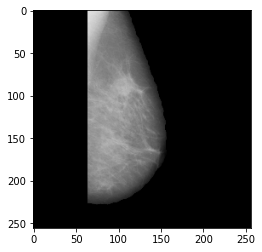

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
bKSbakbdkabcxk None


TypeError: ignored

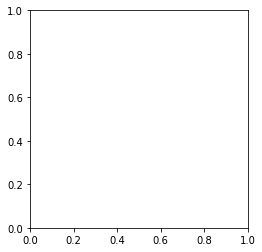

In [ ]:
#img_path = '/content/drive/MyDrive/Dont_change_this_name_ffs/1-1.dcm'
#img_path = '/content/drive/MyDrive/Dont_change_this_name_ffs/mdb003.pgm'
img_path = '/content/drive/MyDrive/MINI_MIAS/malignant_cases/mdb092.png'
prep_obj = PreProcess()
prep_obj.run(img_path)

In [ ]:
img = cv2.imread(img_path)


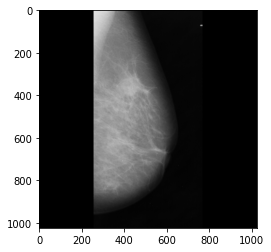

In [ ]:
plt.imshow(img,cmap='gray')

In [ ]:
def apply_artifact_removal(self,image):
        
        print("IMAGE SHAPE 1 : ",image.shape)
        #gray_image = image
        if len(image.shape) == 3:
          img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
          img_grey = image
        #gray_image = color.rgb2gray(image)
        hh,ww = img_grey.shape[:2]
        gray_image = img_grey.astype(np.uint8)
        print("IMAGE SHAPE 2 : ",gray_image.shape)
        print(hh,ww)
        thresh = cv2.threshold(gray_image,0,255,cv2.THRESH_OTSU)[1] 
    
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
        morph = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

        contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        big_contour = max(contours, key=cv2.contourArea)

        mask = np.zeros((hh,ww), dtype=np.uint8)
        cv2.drawContours(mask, [big_contour], 0, 255, cv2.FILLED)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (55,55))
        mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)

        artifact_removed_image = cv2.bitwise_and(image, image, mask=mask)
    
        return artifact_removed_image
    
def apply_resize_image(self,image):
        resized_image = color.gray2rgb(image)
        resized_image = cv2.resize(resized_image, (256, 256))
        
        print('JOTAROOOOOO')
        plt.imshow(resized_image,cmap='gray')
        plt.show()
        print(resized_image)
        
 def apply_crop_image(self,image):
        print('MUDAMUDAMUDMAUDMAUDMUDA')
        plt.imshow(image,cmap='gray')
        plt.show()
        image_copy = np.copy(image) 
        print('AYE DSKGBHFBG')
        plt.imshow(image_copy,cmap='gray')
        plt.show()
        #image_copy = np.array(image, dtype=np.uint8)
        print("DIOOOOOOOOO",image_copy.shape)
        plt.imshow(image_copy,cmap='gray')
        plt.show()
        img_grey = color.rgb2gray(image_copy) #change1 from gray2rgb to rgb2gray
        #img_grey = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
        plt.imshow(img_grey,cmap='gray')
        plt.show()
        
        img_grey = np.array(img_grey, dtype=np.uint8)
        plt.imshow(img_grey,cmap='gray')

        thresh = cv2.threshold(img_grey, 0 , 255, cv2.THRESH_BINARY)[1] 
        x, y, w, h = cv2.boundingRect(thresh) #find the bounding rectangle of nonzero points in the image
        print("jbgkdfgd",x,y,w,h)
        cropped_image = image_copy[y:y+h, x:x+w,:] 
        print("SHAAAAAAAAPEEEEEE : ",cropped_image.shape)
        bgr_cropped_image = color.gray2rgb(cropped_image)
        return bgr_cropped_image

def right_orient_mammogram(self,image):
        left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
        right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
        if(left_nonzero < right_nonzero):
            image = cv2.flip(image, 1)

        return image


            
    
def apply_canny_sobel(self,image):
        canny_image = canny(image, 3.05) #this value works with 90-95% of the images
        return sobel(canny_image)

def get_hough_lines(self,canny_image):
        h, theta, d = hough_line(canny_image)
        lines = list()
        print('\nAll hough lines')
        for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
            print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
            x1 = 0
            y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
            x2 = canny_image.shape[1]
            y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
            lines.append({
                'dist': dist,
                'angle': np.degrees(angle),
                'point1': [x1, y1],
                'point2': [x2, y2]
            })
    
        return lines

def shortlist_hough_lines(self,lines):
        MIN_ANGLE = 10
        MAX_ANGLE = 70
        MIN_DIST  = 5
        MAX_DIST  = 256
    
        shortlisted_lines = [x for x in lines if 
                            (x['dist']>=MIN_DIST) &
                            (x['dist']<=MAX_DIST) &
                            (x['angle']>=MIN_ANGLE) &
                            (x['angle']<=MAX_ANGLE)
                            ]
        print('\nShorlisted lines')
        for i in shortlisted_lines:
            print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        
        return shortlisted_lines
    
def remove_pectoral(self,shortlisted_lines):
        shortlisted_lines.sort(key = lambda x: x['dist'])
        pectoral_line = shortlisted_lines[0]
        d = pectoral_line['dist']
        theta = np.radians(pectoral_line['angle'])
    
        x_intercept = d/np.cos(theta)
        y_intercept = d/np.sin(theta)
    
        return polygon([0, 0, y_intercept], [0, x_intercept, 0])
    
        
def pectoral_removed(self,image):
        #image = self.read_image(img)
        #image_copy = image.astype(np.uint8)
        gray_img = color.rgb2gray(image) #changed
        right_orient_img = self.right_orient_mammogram(gray_img)
        equ_image = exposure.equalize_hist(right_orient_img)

        canny_image = self.apply_canny_sobel(equ_image)
        lines = self.get_hough_lines(canny_image)
        shortlisted_lines = self.shortlist_hough_lines(lines)        
        rr, cc = self.remove_pectoral(shortlisted_lines)
        try:
            image[rr, cc] = 0
        except Exception as e:
            return e

        return image

def remove_graypx(self,image):
        print(image)
        binary_mask = image > 80
        restored = image.copy()
        restored[~binary_mask] = 0
        return restored
    
    
def padding(self,image):
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        old_image_h, old_image_w, channels = image.shape
        new_image_h = 256
        new_image_w = 256
        colour = (0,0,0)
        result_image = np.full((new_image_h,new_image_w,channels),colour,dtype=np.uint8)
  
        #center offset
        x_center = (new_image_w - old_image_w) // 2
        y_center = (new_image_h - old_image_h) // 2

        #copy image into center of resultant image
        result_image[y_center:y_center + old_image_h, x_center:x_center + old_image_w] = image  

        #resize image to 256x256
        padded_resized = cv2.apply_resize_image(result_image, (256, 256))

        return padded_resized

def dcm2png(self,img_path):
        ds = dicom.dcmread(img_path)
        new_image = ds.pixel_array.astype(float)
        scaled_image = (np.maximum(new_image, 0) / new_image.max()) * 255.0
        return scaled_image
      
def pgm2png(self,img_path):
        filename='p1'
        new_file = "{}.png".format(filename)
        dump_path = '/content/drive/MyDrive/Dont_change_this_name_ffs/'
        with Image.open(img_path) as im:
            im.save(dump_path+new_file)
        
        result = cv2.imread(dump_path+new_file)
        return result

def run(self,img_path):
        img = cv2.imread(img_path)
        #img = io.imread(img_path)
        #img = self.dcm2png(img_path)
        #img = self.pgm2png(img_path)
        print("imggggg")
        #plt.imshow(img,cmap='gray')
        
        artiless_img = self.apply_artifact_removal(img)
        print("kadkahdkah",artiless_img)
        plt.imshow(artiless_img,cmap='gray')


        #bgr_img = color.rgb2gray(artiless_img) #change
        resize_img = self.apply_resize_image(artiless_img)
        print("bKSbakbdkabcxk",resize_img)
        plt.imshow(resize_img,cmap='gray')
        crop_img = self.apply_crop_image(resize_img)
        print('CROP IMAGE : ',crop_img)
        
        result_img = self.pectoral_removed(crop_img)
        nongray_img = self.remove_graypx(result_img)
        final_img = self.padding(nongray_img)
        print(len(final_img))
        print(final_img)
        return final_img

IndentationError: ignored